In [1]:
#The variables which are commented are to use the CPU instead of the GPU
#The os variable set in -1 will disable the GPU

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


#The threads variables are used to set the number of threads to be used when CPU test are needed

# Number of threads
#os.environ['TF_NUM_INTEROP_THREADS'] = '32'
#os.environ['TF_NUM_INTRAOP_THREADS'] = '32'

2023-08-08 15:47:53.414159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 15:47:54.379055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16266596895733316379
xla_global_id: -1
]


2023-08-08 15:47:55.458539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-08 15:47:55.458585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: ip-172-31-19-119
2023-08-08 15:47:55.458594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: ip-172-31-19-119
2023-08-08 15:47:55.458677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.86.5
2023-08-08 15:47:55.458707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.5
2023-08-08 15:47:55.458714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.86.5


Correlation Matrix:
                         id       dur     spkts     dpkts    sbytes    dbytes  \
id                 1.000000  0.019190 -0.049479 -0.090849  0.000928 -0.058138   
dur                0.019190  1.000000  0.258890  0.188382  0.204422  0.149705   
spkts             -0.049479  0.258890  1.000000  0.383221  0.964393  0.203804   
dpkts             -0.090849  0.188382  0.383221  1.000000  0.184280  0.973445   
sbytes             0.000928  0.204422  0.964393  0.184280  1.000000  0.009969   
dbytes            -0.058138  0.149705  0.203804  0.973445  0.009969  1.000000   
rate               0.263971 -0.118622 -0.073668 -0.093065 -0.027353 -0.055538   
sttl               0.447072  0.008617 -0.099579 -0.183142 -0.019939 -0.128600   
dttl              -0.014507  0.053580  0.063234  0.047416  0.058397  0.019371   
sload              0.111997 -0.079202 -0.049232 -0.062484 -0.017320 -0.037318   
dload             -0.265091 -0.049026  0.075482  0.137395 -0.007372  0.103487   
sloss   

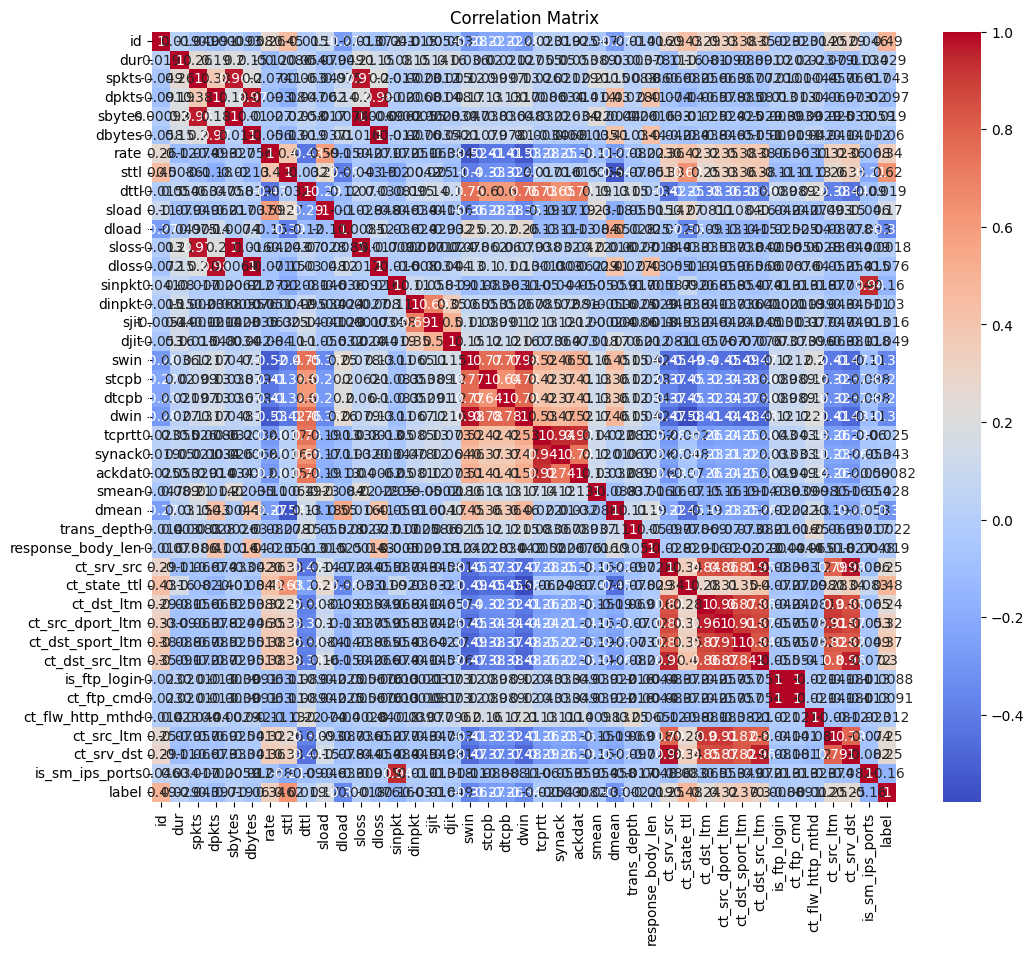

Dropped columns: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'dttl', 'sloss', 'dloss', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'trans_depth', 'response_body_len', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd']
Binary Classification - Training Time: 0.19074797630310059 seconds
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0


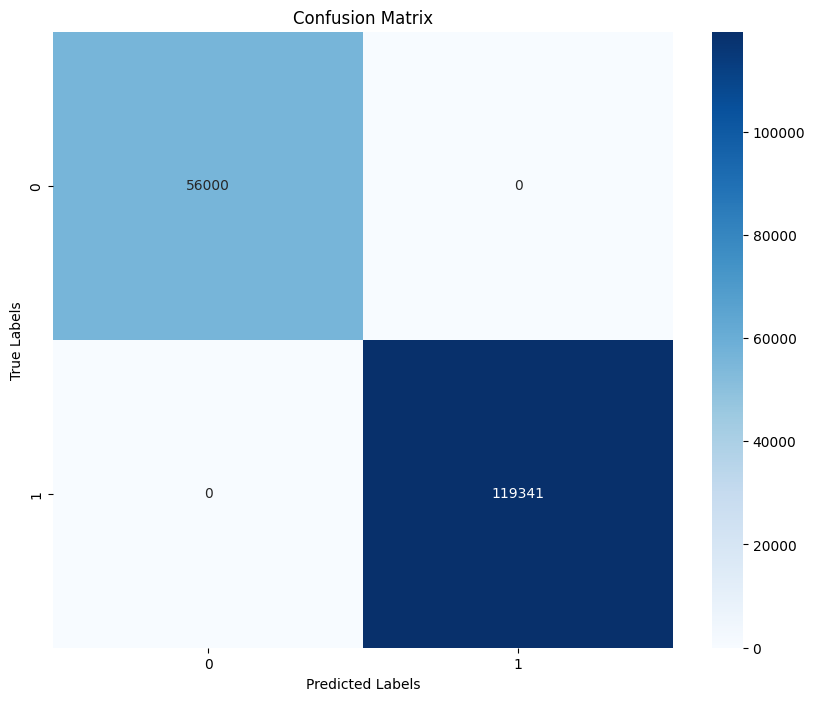

Confusion Matrix:
[[ 56000      0]
 [     0 119341]]


In [2]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

train_data = pd.read_csv('UNSW_NB15_training-set.csv')
test_data = pd.read_csv('UNSW_NB15_testing-set.csv')

# Separate features and labels
train_features = train_data.drop('attack_cat', axis=1)
train_labels = train_data['label']  # Assuming "label" column is the binary target
test_features = test_data.drop('attack_cat', axis=1)
test_labels = test_data['label']  # Assuming "label" column is the binary target

# Concatenate the training and testing datasets
combined_features = pd.concat([train_features, test_features], axis=0)

# Identify categorical columns
categorical_cols = combined_features.select_dtypes(include=['object']).columns

# Drop categorical columns before calculating the correlation matrix
combined_features_numeric = combined_features.drop(categorical_cols, axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_features_numeric.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Set the correlation threshold
correlation_threshold = 0.1

# Create a boolean mask of columns to drop
columns_to_drop = []
for column in correlation_matrix.columns:
    if column != "label" and abs(correlation_matrix[column]["label"]) < correlation_threshold:
        columns_to_drop.append(column)

# Drop the less important columns from the dataset combined_features
updated_combined_features = combined_features.drop(columns_to_drop, axis=1)

# Print the columns that were dropped
print("Dropped columns:", columns_to_drop)

# Identify categorical columns
categorical_cols = updated_combined_features.select_dtypes(include=['object']).columns

# Perform one-hot encoding on the combined dataset
updated_combined_features_encoded = pd.get_dummies(updated_combined_features, columns=categorical_cols)

# Split the combined dataset into training and validation subsets
X_train_encoded = updated_combined_features_encoded[:len(train_features)]
X_val_encoded = updated_combined_features_encoded[len(train_features):]

# Split the corresponding labels for the training and validation datasets
y_train = train_labels  # You can change the target column for training here
y_val = test_labels     # You can change the target column for validation here


# Wrap the model creation and training within a MirroredStrategy scope
#The line of code 'GPUS = ["GPU:0"]' and 'strategy = tf.distribute.MirroredStrategy(GPUS)' should be commented when CPU is selected

GPUS = ["GPU:0"]
strategy = tf.distribute.MirroredStrategy(GPUS)

# The strategy line code 'with strategy.scope():' should be commented when the CPU is used for the data processing
# The tabular space should be also eliminated to avoid errors

with strategy.scope():
    # Train the decision tree model
    start_time_binary = time.time()
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_encoded, y_train)
    end_time_binary = time.time()
    
# Calculate training time for binary classification
training_time_binary = end_time_binary - start_time_binary
print("Binary Classification - Training Time:", training_time_binary, "seconds")

# Make predictions on the validation dataset
val_predictions = model.predict(X_val_encoded)

# Calculate evaluation metrics
val_accuracy = accuracy_score(y_val, val_predictions)
val_precision = precision_score(y_val, val_predictions, average='macro')
val_recall = recall_score(y_val, val_predictions, average='macro')
val_f1_score = f1_score(y_val, val_predictions, average='macro')

# Print evaluation metrics
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1 Score: {val_f1_score}")

# Calculate the confusion matrix
cm = confusion_matrix(y_val, val_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
